# Unscented Kalman Filter

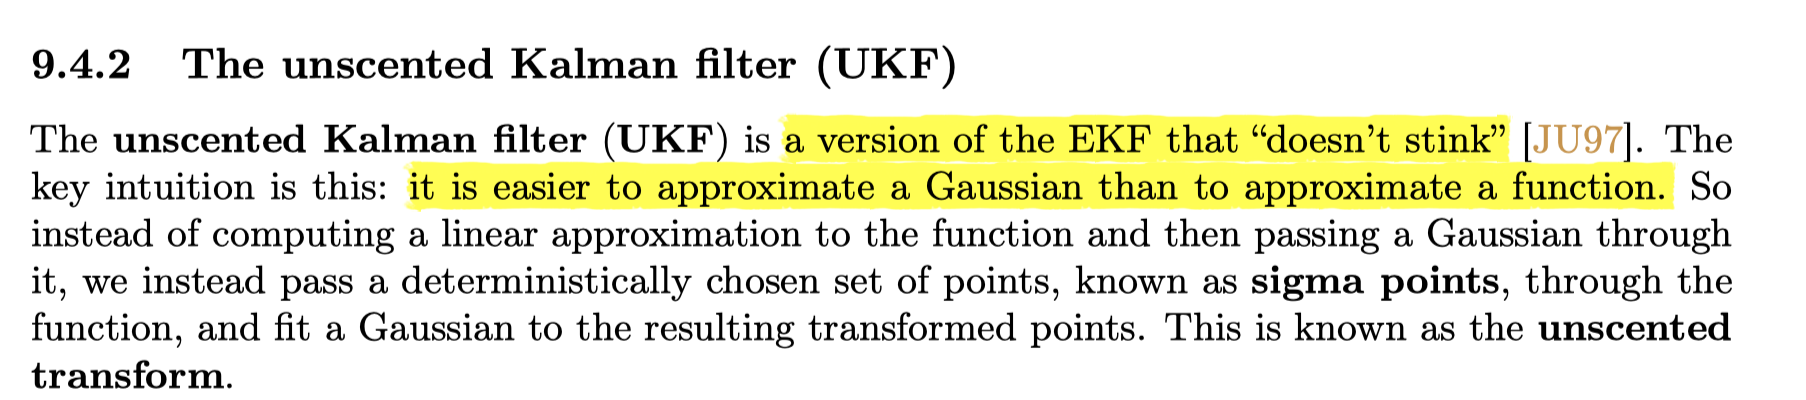

In [1]:
import jax.numpy as jnp
from jax import random
from jax.scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

## The uncented transform

### One-dimensional

In [3]:
key = random.PRNGKey(314)
nsamples = 2000
d = 1
μ, σ = 0, 1
x = random.normal(key, (nsamples,)) * σ + μ

<AxesSubplot:ylabel='Count'>

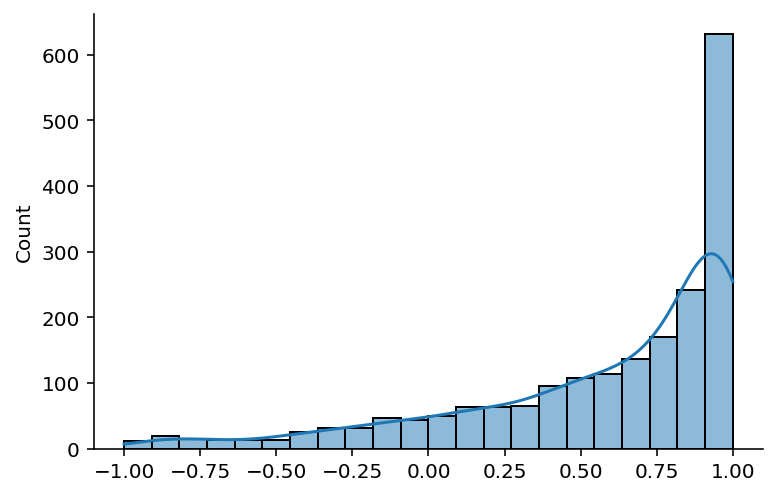

In [4]:
def f(x): return jnp.cos(x)
sns.histplot(f(x), kde=True)

First, we create a set of $2d + 1$ sigma points

In [5]:
α, β, κ = 1, 0, 2
λ = α ** 2 * (d + κ) - d

In [6]:
sigma_points = jnp.array([μ, μ + jnp.sqrt(d + λ) * σ, μ - jnp.sqrt(d + λ) * σ])
sigma_points
y = f(sigma_points)
y

DeviceArray([ 1.        , -0.16055651, -0.16055651], dtype=float32)

In [7]:
wm_0 = λ / (d + λ)
wc_0 = λ / (d + λ) + (1 - α ** 2 + β)

wm_i = wc_i = 1 / (2 * (d + λ))

wm_vec = jnp.asarray([wm_0, wm_i, wm_i])
wc_vec = jnp.asarray([wc_0, wc_i, wc_i])

In [8]:
μy = wm_vec @ y
μy

DeviceArray(0.6131478, dtype=float32)

In [9]:
σy = np.sqrt((y - μy) ** 2 @ wc_vec)
σy

0.5470916

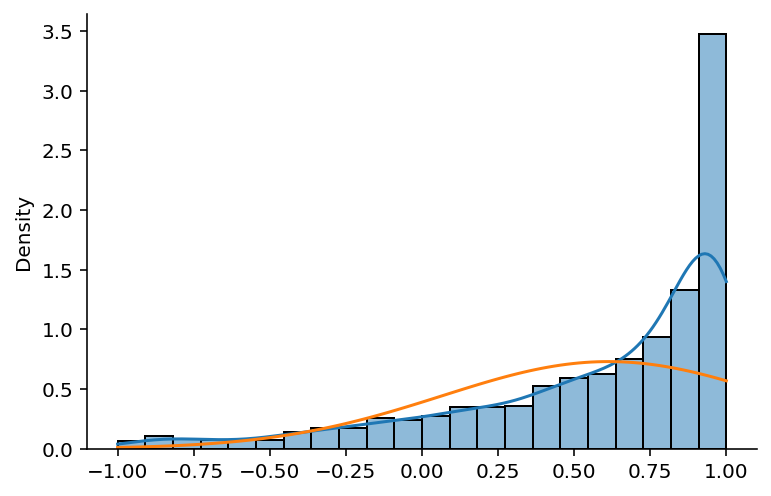

In [10]:
yrange = jnp.linspace(-1, 1, 100)

sns.histplot(f(x), kde=True, stat="density")
plt.plot(yrange, stats.norm.pdf(yrange, loc=μy, scale=σy), c="tab:orange")

### Bidimensional

In [11]:
key = random.PRNGKey(314)
nsamples = 1000
d = 2
μ = jnp.zeros(2)
Σ = jnp.array([[1, 0.5], [0.5, 1]])
x = random.multivariate_normal(key, μ, Σ, (nsamples, ))

In [12]:
α, β, κ = 1, 0, 2
λ = α ** 2 * (d + κ) - d

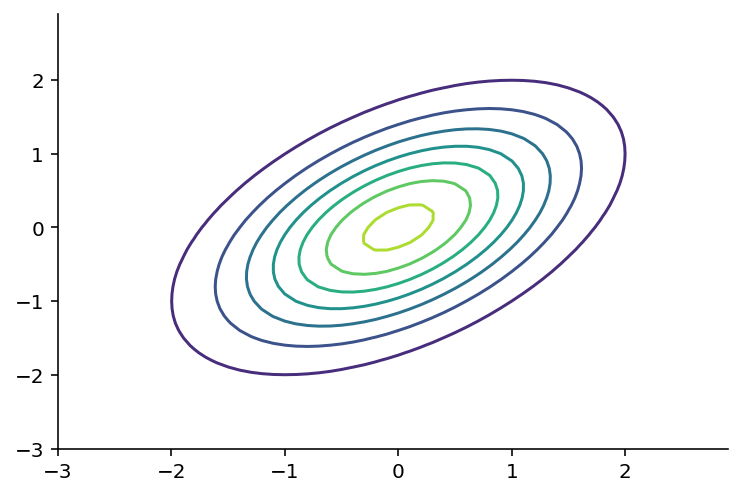

In [13]:
X = jnp.mgrid[-3:3:0.1, -3:3:0.1]
Px = jnp.apply_along_axis(lambda x: stats.multivariate_normal.pdf(x, μ, Σ), 0, X)
plt.contour(*X, Px)

In [14]:
def f(x): return jnp.asarray([x[1], x[0] - x[0] ** 3])

y_samp = f(x.T).T
y_samp.shape

(1000, 2)

<AxesSubplot:>

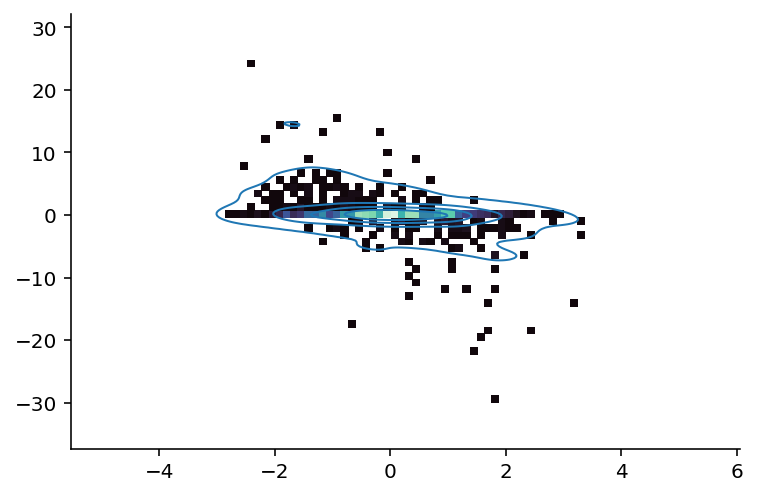

In [15]:
sns.histplot(x=y_samp[:, 0], y=y_samp[:, 1], bins=50, cmap="mako")
sns.kdeplot(x=y_samp[:, 0], y=y_samp[:, 1], levels=5, linewidths=1, cut=8, gridsize=300)

<AxesSubplot:>

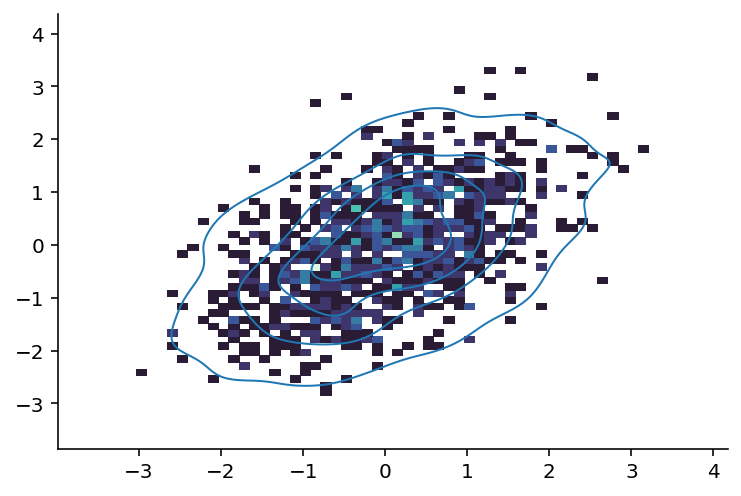

In [16]:
sns.histplot(x=x[:, 0], y=x[:, 1], bins=50, cmap="mako")
sns.kdeplot(x=x[:, 0], y=x[:, 1], levels=5, linewidths=1)

In [17]:
comp1 = μ[:, None] + np.sqrt((d + λ) * Σ)
comp2 = μ[:, None] - np.sqrt((d + λ) * Σ)
sigma_points = jnp.c_[μ, comp1, comp2]
sigma_points

DeviceArray([[ 0.       ,  2.       ,  1.4142135, -2.       , -1.4142135],
             [ 0.       ,  1.4142135,  2.       , -1.4142135, -2.       ]],            dtype=float32)

In [18]:
wm_vec = jnp.array([1 / (2 * (d + λ)) if i > 0 else λ / (d + λ) for i in range(2 * d + 1)])
wc_vec = jnp.array([1 / (2 * (d + λ)) if i > 0 else λ / (d + λ) + (1 - α ** 2 + β) for i in range(2 * d + 1)])

wm_vec.shape

(5,)

In [19]:
y = f(sigma_points)
y.shape

(2, 5)

In [20]:
μy = y @ wm_vec
μy

DeviceArray([0.0000000e+00, 1.4901161e-08], dtype=float32)

In [21]:
dev_Σ = (y - μy[:, None])
Σy = jnp.einsum("i,ji,ki->jk", wm_vec, dev_Σ, dev_Σ)
Σy

DeviceArray([[ 1.5      , -2.8284268],
             [-2.8284268,  9.5      ]], dtype=float32)

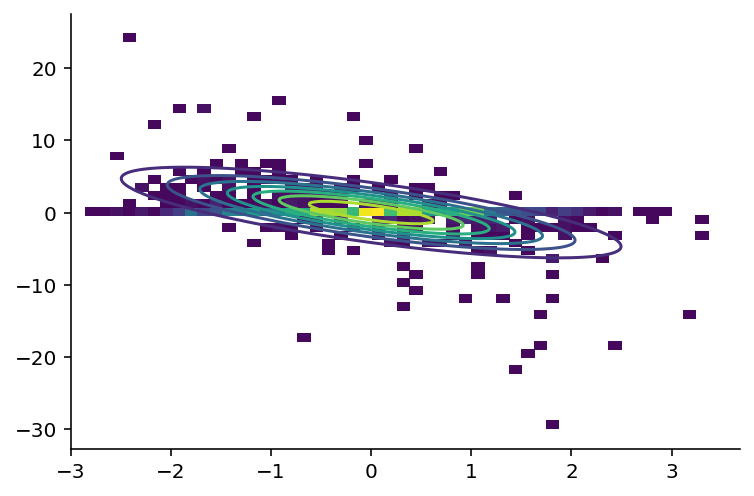

In [22]:
X = jnp.mgrid[-3:3:0.1, -20:20:0.1]
Px = jnp.apply_along_axis(lambda x: stats.multivariate_normal.pdf(x, μy, Σy), 0, X)
sns.histplot(x=y_samp[:, 0], y=y_samp[:, 1], bins=50, cmap="viridis")
plt.contour(*X, Px)

## The unscented Kalman filter

In [361]:
from jax.ops import index_update
dt = 0.4
def f(x): return x + dt * jnp.asarray([jnp.sin(x[1]), jnp.cos(x[0])])
def fx(x): return x
#def f(x): return x + dt * jnp.asarray([x[1], x[0]-x[0] ** 3])

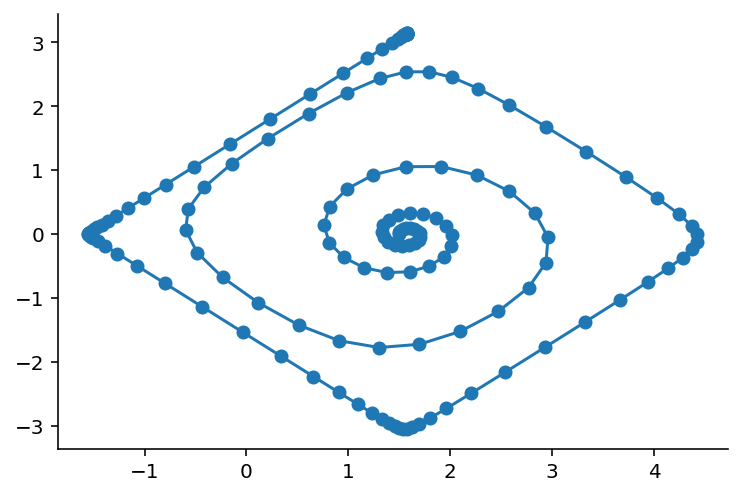

In [464]:
x0 = jnp.array([1.5, 0])

xn = x0.copy()
nsteps = 150
hist = jnp.zeros((nsteps, 2))
hist = index_update(hist, 0, xn)
for n in range(1, nsteps):
    xn = f(xn)
    hist = index_update(hist, n, xn)
plt.plot(*hist.T, marker="o")

In [557]:
Q = jnp.eye(2) * 0.001
R = jnp.eye(2) * 0.05


key = random.PRNGKey(314)
key, key_system_noise, key_obs_noise = random.split(key, 3)
state_errs = random.multivariate_normal(key_system_noise, jnp.zeros(2), Q, (nsteps,))
obs_errs = random.multivariate_normal(key_obs_noise, jnp.zeros(2), R, (nsteps,))

In [561]:
dt

0.4

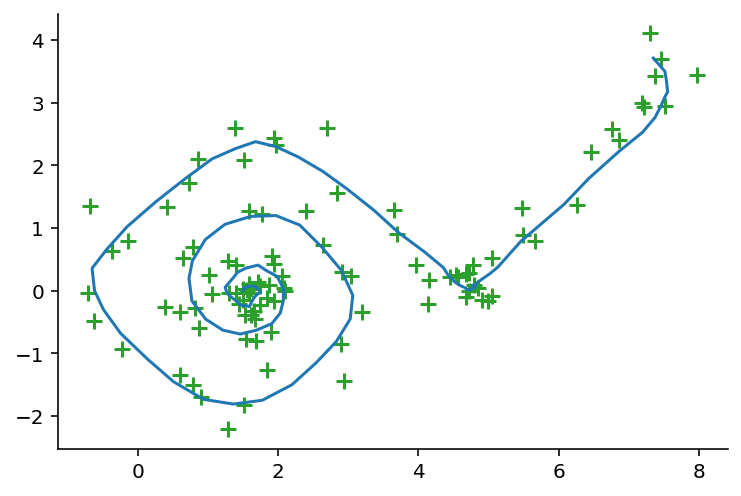

In [559]:
state_n = x0.copy()

nsteps = 100
state_hist = jnp.zeros((nsteps, 2))
obs_hist = jnp.zeros((nsteps, 2))

state_hist = index_update(state_hist, 0, state_n)
obs_hist = index_update(obs_hist, 0, f(state_n))

for n in range(1, nsteps):
    state_n = f(state_n) + state_errs[n]
    obs_n = fx(state_n) + obs_errs[n]
    
    state_hist = index_update(state_hist, n, state_n)
    obs_hist = index_update(obs_hist, n, obs_n)
    
plt.plot(*state_hist.T)
plt.scatter(*obs_hist.T, s=60, c="tab:green", marker="+")

In [562]:
d = 2
α, β, κ = 1, 0, 2
λ = α ** 2 * (d + κ) - d

γ = jnp.sqrt(d + λ)

In [563]:
comp1 = μ[:, None] + γ * np.sqrt(Q)
comp2 = μ[:, None] - γ * np.sqrt(Q)
sigma_points = jnp.c_[μ, comp1, comp2]
sigma_points

DeviceArray([[ 0.    ,  0.0632,  0.    , -0.0632,  0.    ],
             [ 0.    ,  0.    ,  0.0632,  0.    , -0.0632]],            dtype=float32)

In [564]:
jnp.set_printoptions(precision=4, suppress=True)

In [565]:
z_bar = f(sigma_points)
z_bar

DeviceArray([[ 0.    ,  0.0632,  0.0253, -0.0632, -0.0253],
             [ 0.4   ,  0.3992,  0.4632,  0.3992,  0.3368]],            dtype=float32)

In [566]:
wm_vec = jnp.array([1 / (2 * (d + λ)) if i > 0 else λ / (d + λ) for i in range(2 * d + 1)])
wc_vec = jnp.array([1 / (2 * (d + λ)) if i > 0 else λ / (d + λ) + (1 - α ** 2 + β) for i in range(2 * d + 1)])

In [567]:
mu_bar = z_bar @ wm_vec

In [568]:
Sigma_bar = (z_bar - mu_bar[:, None])
Sigma_bar = jnp.einsum("i,ji,ki->jk", wm_vec, Sigma_bar, Sigma_bar) + Q

In [569]:
comp1 = mu_bar[:, None] + γ * np.sqrt(Q)
comp2 = mu_bar[:, None] - γ * np.sqrt(Q)
sigma_points = jnp.c_[mu_bar, comp1, comp2]
sigma_points

DeviceArray([[ 0.    ,  0.0632,  0.    , -0.0632,  0.    ],
             [ 0.3998,  0.3998,  0.463 ,  0.3998,  0.3366]],            dtype=float32)

In [570]:
x_bar = fx(z_bar)
x_bar

DeviceArray([[ 0.    ,  0.0632,  0.0253, -0.0632, -0.0253],
             [ 0.4   ,  0.3992,  0.4632,  0.3992,  0.3368]],            dtype=float32)

In [571]:
x_hat = x_bar @ wm_vec
x_hat

DeviceArray([0.    , 0.3998], dtype=float32)

In [572]:
S = (x_bar - x_hat[:, None])
S = jnp.einsum("i,ji,ki->jk", wm_vec, S, S) + R

In [573]:
Sigma_bar_y = (z_bar - mu_bar[:, None])
Sigma_bar_y = jnp.einsum("i,ji,ki->jk", wm_vec, Sigma_bar_y, Sigma_bar_y)
Sigma_bar_y

DeviceArray([[0.0012, 0.0004],
             [0.0004, 0.001 ]], dtype=float32)

In [574]:
Kt = Sigma_bar_y @ jnp.linalg.inv(S)
Kt

DeviceArray([[0.0226, 0.0077],
             [0.0077, 0.0196]], dtype=float32)

In [575]:
mu_t = mu_bar + Kt @ (obs_hist[1] - x_hat)
mu_t

DeviceArray([0.0345, 0.4008], dtype=float32)

In [576]:
Sigma_t = Sigma_bar - Kt @ S @ Kt.T
Sigma_t

DeviceArray([[0.0021, 0.0004],
             [0.0004, 0.002 ]], dtype=float32)

### All together

In [577]:
d = 2
α, β, κ = 1, 0, 2
λ = α ** 2 * (d + κ) - d

gamma = jnp.sqrt(d + λ)

In [578]:
def sqrtm(M):
    """
    Matrix square-root
    """
    evals, evecs = jnp.linalg.eigh(M)
    R = evecs @ jnp.sqrt(jnp.diag(evals)) @ jnp.linalg.inv(evecs)
    return R

In [579]:
mu_t = obs_hist[0]
Sigma_t = Q.copy()

mu_hist = jnp.zeros((nsteps, 2))
Sigma_hist = jnp.zeros((nsteps, 2, 2))

mu_hist = index_update(mu_hist, 0, mu_t)
Sigma_hist = index_update(Sigma_hist, 0, Sigma_t)

for n in range(1, nsteps):
    comp1 = mu_t[:, None] + gamma * sqrtm(Sigma_t)
    comp2 = mu_t[:, None] - gamma * sqrtm(Sigma_t)
    sigma_points = jnp.c_[mu_t, comp1, comp2]

    z_bar = f(sigma_points)
    mu_bar = z_bar @ wm_vec
    Sigma_bar = (z_bar - mu_bar[:, None])
    Sigma_bar = jnp.einsum("i,ji,ki->jk", wm_vec, Sigma_bar, Sigma_bar) + Q

    comp1 = mu_bar[:, None] + gamma * sqrtm(Sigma_bar)
    comp2 = mu_bar[:, None] - gamma * sqrtm(Sigma_bar)
    sigma_points = jnp.c_[mu_bar, comp1, comp2]

    x_bar = fx(z_bar)
    x_hat = x_bar @ wm_vec
    St = (x_bar - x_hat[:, None])
    St = jnp.einsum("i,ji,ki->jk", wm_vec, St, St) + R

    Sigma_bar_y = (z_bar - mu_bar[:, None])
    Sigma_bar_y = jnp.einsum("i,ji,ki->jk", wm_vec, Sigma_bar_y, Sigma_bar_y)
    Kt = Sigma_bar_y @ jnp.linalg.inv(St)

    mu_t = mu_bar + Kt @ (obs_hist[n] - x_hat)
    Sigma_t = Sigma_bar - Kt @ St @ Kt.T
    
    mu_hist = index_update(mu_hist, n, mu_t)
    Sigma_hist = index_update(Sigma_hist, n, Sigma_t)

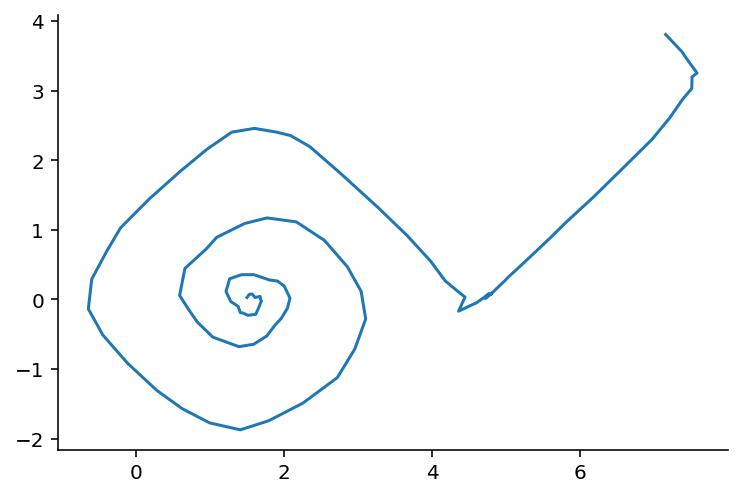

In [580]:
plt.plot(*mu_hist.T)

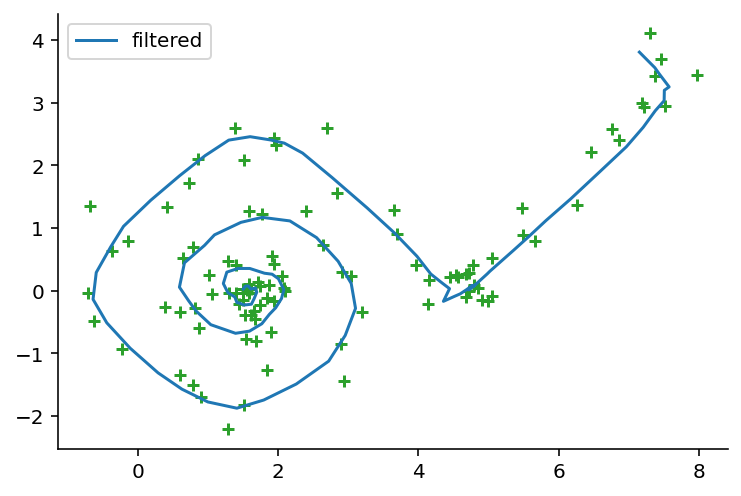

In [581]:
plt.scatter(*obs_hist.T, marker="+", color="tab:green")
plt.plot(*mu_hist.T, label="filtered")
plt.legend()